In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import nilmtk
import utils
from pgd import pgd
from nnls import nnls
%load_ext autoreload
%autoreload 2

### Exploración de la Base AMPDs v2
Se utuliza nilmtk para la carga de datos. AMPds se puede bajar desde https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/FIE0S4. Dentro del zip esta el archivo AMPds2.h5

In [5]:
path_h5  = 'ampds2.h5'
ds = nilmtk.DataSet(path_h5)

Exprolemos las fechas y largos del dataset.

In [6]:
def get_fechas(x):
    index = next(x.load()).index
    return index[0], index[-1]

def get_largos(x):
    serie = next(x.load())
    return len(serie)

fechas = list(map(get_fechas, ds.buildings[1].elec.all_meters()))
largos = list(map(get_largos, ds.buildings[1].elec.all_meters()))

In [7]:
fechas

[(Timestamp('2012-04-01 00:00:00-0700', tz='America/Vancouver'),
  Timestamp('2014-03-31 23:59:00-0700', tz='America/Vancouver')),
 (Timestamp('2012-04-01 00:00:00-0700', tz='America/Vancouver'),
  Timestamp('2014-03-31 23:59:00-0700', tz='America/Vancouver')),
 (Timestamp('2012-04-01 00:00:00-0700', tz='America/Vancouver'),
  Timestamp('2014-03-31 23:59:00-0700', tz='America/Vancouver')),
 (Timestamp('2012-04-01 00:00:00-0700', tz='America/Vancouver'),
  Timestamp('2014-03-31 23:59:00-0700', tz='America/Vancouver')),
 (Timestamp('2012-04-01 00:00:00-0700', tz='America/Vancouver'),
  Timestamp('2014-03-31 23:59:00-0700', tz='America/Vancouver')),
 (Timestamp('2012-04-01 00:00:00-0700', tz='America/Vancouver'),
  Timestamp('2014-03-31 23:59:00-0700', tz='America/Vancouver')),
 (Timestamp('2012-04-01 00:00:00-0700', tz='America/Vancouver'),
  Timestamp('2014-03-31 23:59:00-0700', tz='America/Vancouver')),
 (Timestamp('2012-04-01 00:00:00-0700', tz='America/Vancouver'),
  Timestamp('2014-

In [8]:
ds.set_window(start='2012-04-01', end='2013-03-01')

In [9]:
largos

[1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200,
 1051200]

Notar que todas tienen los mismos largos y mismas fechas. **Es decir, esta muestrados al mismo tiempo!!! Esto es ideal para no tener que realizar pre-procesamiento de alineado**

### Obtención de matrices para resolución del problema
Se intenta resolver un problema similar al del paper https://arxiv.org/pdf/1704.07308.pdf.
El problema es el siguiente:
$$
\min _{A}\|G-H A\|_{F}^{2} 
$$
$$\text{  s.t.  $A_{i,j}>0$ $\forall i,j$}$$
con:
$$ G =
\left[\begin{array}{c}
\bar{X} \\
\beta U
\end{array}\right]$$


$$ H = 
\left[\begin{array}{c}
D \\
\beta Q
\end{array}\right]
$$

- $D$ una matriz cuyas columnas son las bases del consumo de energeia electrico (se espera poder estimar el consumo sea una combinación lineal de estos vectores).

- $X$ un matriz en la que cada columna representa el consumo electrico de que se quiere proyectar sobre las columnas de $D$

- $U$ matriz de $1's$, su objetivo es regularizar el problema con al sum-to-k condition, como se explica en el paper

- $Q$ mismo objetivo que $U$

- $\beta$ fuerza regularizadora. En el paper dice ser un valor pequeño.

Algunas ideas extras:
1. Incluir informacion de la cantida de ejemplos que se esta queriendo proyectar, ya que de esto depende poder encontrar un $\beta$ unico para cualquier cantidad de ejemplos.
2. Restrigir a que $A$<1, ya que un electrodomestico no deberia aportar más que 1.


In [10]:
# La función get_D divide la serie de consumo por días y la retorna
def label(x):
    if x.is_site_meter():
        return {'original_name': 'WHM','room': 'Whole-House Meter'}
    else:
        return x.appliances[0].metadata
def label_and_D(x):
    return label(x), utils.get_D(x)

In [11]:
data_submters = list(map(label_and_D, ds.buildings[1].elec.submeters().all_meters()))
data_mains = list(map(label_and_D, [ds.buildings[1].elec.mains()]))

In [13]:
data_submters[0]

({'original_name': 'B1E',
  'room': 'North Bedroom',
  'type': 'light',
  'description': 'Plugs and lights',
  'instance': 1,
  'meters': [2],
  'dataset': 'AMPds',
  'building': 1},
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [14]:
dict(enumerate(map(lambda x:x[0]['description'], data_submters)))

{0: 'Plugs and lights',
 1: 'Plugs and lights',
 2: 'Partial Plugs and lights',
 3: 'Clothes Dryer',
 4: 'Clothes Washer',
 5: 'Plugs',
 6: 'Dishwasher',
 7: 'Electronics Workbench',
 8: 'Security/Network Equipment',
 9: 'Fridge',
 10: 'Forced Air Furnace Fan and Thermostat',
 11: 'Sub-Panel, Detached Building',
 12: 'Heat Pump',
 13: 'Instant Hot Water Unit',
 14: 'Home Office',
 15: 'Plugs',
 16: 'Sub-Panel, Basement, 1 Occupant',
 17: 'Entertainment:TV, PVR, AMP',
 18: 'Utility Plug',
 19: 'Wall Oven'}

In [15]:
list(enumerate(map(lambda x:x[1].shape, data_submters)))

[(0, (1440, 301)),
 (1, (1440, 319)),
 (2, (1440, 313)),
 (3, (1440, 160)),
 (4, (1440, 122)),
 (5, (1440, 197)),
 (6, (1440, 106)),
 (7, (1440, 203)),
 (8, (1440, 333)),
 (9, (1440, 333)),
 (10, (1440, 333)),
 (11, (1440, 333)),
 (12, (1440, 333)),
 (13, (1440, 333)),
 (14, (1440, 333)),
 (15, (1440, 1)),
 (16, (1440, 333)),
 (17, (1440, 333)),
 (18, (1440, 333)),
 (19, (1440, 333))]

In [16]:
data_mains[0]

({'original_name': 'WHM', 'room': 'Whole-House Meter'},
 array([[ 8.3,  6.6, 19.8, ...,  5.8,  7.1,  4.9],
        [ 8.2,  6.6, 19.9, ...,  7.2,  6. ,  4.9],
        [ 8. ,  6.4, 19.8, ...,  7. ,  6.2,  4.9],
        ...,
        [ 4.3, 24.8,  8.4, ...,  7. ,  4.9,  6.2],
        [ 4.3, 23.1,  8.1, ...,  7.1,  4.9,  7.3],
        [ 5.7, 19.9,  7.9, ...,  7. ,  5. ,  7.3]], dtype=float32))

In [18]:
array_por_dia = list(map(lambda x:x[1], data_submters))
array_agregado_por_dia = list(map(lambda x:x[1], data_mains))

Considemermos como primer aproximación. Estimar unicamente el consumo de la heladera a partir de otras heladeras.

In [88]:
fridge = array_por_dia[9]
ClothesDryer = array_por_dia[3]
ClothesWasher = array_por_dia[4]
Plugs = array_por_dia[5]
Dishwasher = array_por_dia[6]

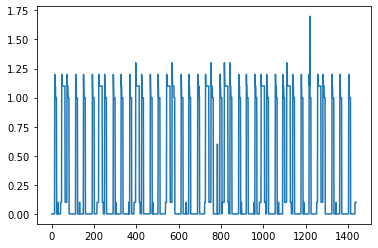

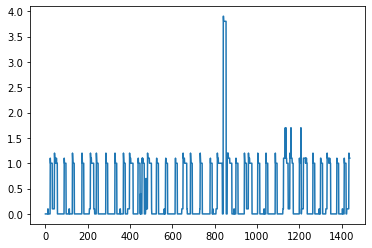

In [21]:
plt.plot(fridge[:,0])
plt.figure()
plt.plot(fridge[:,-1])

In [22]:
fridge

array([[0. , 1.2, 0. , ..., 1. , 1. , 0. ],
       [0. , 1.2, 0. , ..., 1. , 0. , 0. ],
       [0. , 1.1, 0. , ..., 1. , 0. , 0. ],
       ...,
       [0.1, 1. , 1. , ..., 1. , 0. , 1.1],
       [0.1, 0.8, 1. , ..., 1. , 0. , 1.1],
       [0.1, 0. , 1. , ..., 1. , 0. , 1.1]], dtype=float32)

Vamos a estimar los ultimos 2 días a partir de los primeros 5. Empezemos con el caso más sencillo posbile, $\beta=0$. Es decir,
$$
\min _{A}\|X-D A\|_{F}^{2} 
$$
$$\text{  s.t.  $A_{i,j}>0$ $\forall i,j$}$$

### Calculo de D

In [55]:
list(zip(np.cumsum([a.shape[1] for a in array_por_dia]), (map(lambda x:x[0]['description'], data_submters))))

[(301, 'Plugs and lights'),
 (620, 'Plugs and lights'),
 (933, 'Partial Plugs and lights'),
 (1093, 'Clothes Dryer'),
 (1215, 'Clothes Washer'),
 (1412, 'Plugs'),
 (1518, 'Dishwasher'),
 (1721, 'Electronics Workbench'),
 (2054, 'Security/Network Equipment'),
 (2387, 'Fridge'),
 (2720, 'Forced Air Furnace Fan and Thermostat'),
 (3053, 'Sub-Panel, Detached Building'),
 (3386, 'Heat Pump'),
 (3719, 'Instant Hot Water Unit'),
 (4052, 'Home Office'),
 (4053, 'Plugs'),
 (4386, 'Sub-Panel, Basement, 1 Occupant'),
 (4719, 'Entertainment:TV, PVR, AMP'),
 (5052, 'Utility Plug'),
 (5385, 'Wall Oven')]

In [77]:
array_por_dia_ = list(map(lambda x:x[:,:-5], array_por_dia))
array_por_dia_[0].shape, array_por_dia[0].shape

((1440, 296), (1440, 301))

In [237]:
D = np.concatenate(array_por_dia_, axis=1)[:,:933]#fridge[:, :-1]
#X = np.concatenate(array_agregado_por_dia, axis=1)#fridge[:, -1:]

X = ClothesDryer[:, -5:]+Dishwasher[:,-5:] #+ np.clip(np.random.normal(scale=0, size=X.shape), 0, None)

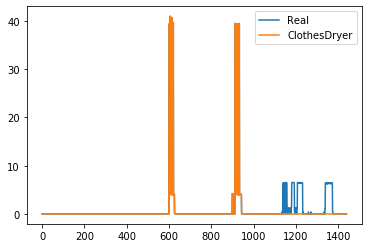

In [238]:
i=0
plt.plot(X[:, i], label='Real')
plt.plot(ClothesDryer[:, -5], label='ClothesDryer')
plt.legend()

In [239]:
D.shape

(1440, 933)

In [240]:
X.shape

(1440, 5)

Text(0, 0.5, 'corriente')

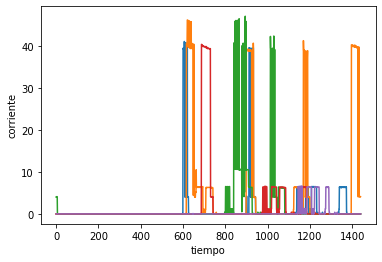

In [241]:
# plt.figure()
# for i in range(D.shape[1]):
#     plt.plot(D[:,i])
plt.figure()
for i in range(X.shape[1]):
    plt.plot(X[:,i])

plt.xlabel('tiempo')
plt.ylabel('corriente')

In [242]:
# pro_pgd, cost_pgd = pgd(D, X[:, 0:1], weight_decay=1e0)
# cost_pgd
#pro_nnls, cost_nnls = nnls(D, X[:, 0:1])
#print(cost_pgd, cost_nnls)
# plt.figure()
# plt.plot(X[:,])

In [263]:
from fnnls import fnnls
from time import time
from scipy.optimize import nnls
#from nnls import nnls

i = 0
pro_nnls, cost_nnls = pgd(D, X[:, i])#, max_iter=100000)

100%|██████████| 10000/10000 [00:06<00:00, 1579.48it/s]


Cantidad de iteraciones: 9999
Tiempo: 6.46


In [264]:
pro_nnls.sum()

23.477422401972174

In [265]:
cost_nnls

33974.95313652826

In [266]:
#pro_nnls

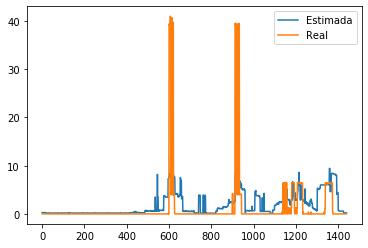

In [267]:
plt.plot((D*pro_nnls).sum(axis=1), label='Estimada')
plt.plot(X[:, i], label='Real')
plt.legend()

In [268]:
limits = list(zip(np.cumsum([a.shape[1] for a in array_por_dia]), (map(lambda x:x[0]['description'], data_submters))))
limits.insert(0,(0,''))
for i in range(1, len(limits)):
    ini = limits[i-1][0]
    fin = limits[i][0]
    suma = pro_nnls[ini:fin].sum()
    if limits[i][1]!='Dishwasher':
        pro_nnls[ini:fin]=0
    print(f'{suma:.2f}', limits[i][1])
    

15.45 Plugs and lights
1.44 Plugs and lights
6.59 Partial Plugs and lights
0.00 Clothes Dryer
0.00 Clothes Washer
0.00 Plugs
0.00 Dishwasher
0.00 Electronics Workbench
0.00 Security/Network Equipment
0.00 Fridge
0.00 Forced Air Furnace Fan and Thermostat
0.00 Sub-Panel, Detached Building
0.00 Heat Pump
0.00 Instant Hot Water Unit
0.00 Home Office
0.00 Plugs
0.00 Sub-Panel, Basement, 1 Occupant
0.00 Entertainment:TV, PVR, AMP
0.00 Utility Plug
0.00 Wall Oven


In [44]:
from utils import PCEC
PCEC(X[:,0], estimated)

0.9100010824592435

$$f(A) = ||X - DA||_F^2$$
$$\frac{\partial f}{\partial A} (A)= -2D^T(X-DA)$$